In [1]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

2024-04-22 09:00:55.676016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 09:00:55.713553: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Check tensorflow device
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10694190461673030096
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23365222400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11147155746020048340
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23365222400
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18439075576350690783
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9"
xla_global_id: 2144165316
]


2024-04-22 09:01:00.990212: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 09:01:01.121020: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:01.121165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:01.132050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had 

In [3]:
# hipermarametros

batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 100
epsilon_std = 0.7

In [4]:
# create incoder

x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation="relu")(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(
    lambda args: args[0]
    + K.random_normal(
        shape=(K.shape(args[0])[0], latent_dim), mean=0.0, stddev=epsilon_std
    )
    * K.exp(args[1] / 2),
    output_shape=(latent_dim,),
)([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

2024-04-22 09:01:10.095678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:10.095886: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:10.096011: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:10.096116: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-22 09:01:10.096228: I tensorflow/compiler/xla/stream_executo

In [5]:
# create sampling function


def sampling(args: tuple):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [6]:
# create decoder

input_decoder = Input(shape=(latent_dim,), name="decoder_input")

decoder_h = Dense(intermediate_dim, activation="relu", name="decoder_h")(input_decoder)

x_decoded = Dense(original_dim, activation="sigmoid", name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")

In [7]:
# create vae
output_combined = decoder(encoder(x)[2])
vae = Model(x, output_combined)
vae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               201988    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               202256    
                                                                 
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


In [8]:
# loss function
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

vae.add_loss(K.mean(kl_loss) / original_dim)
vae.compile(optimizer="rmsprop", loss="binary_crossentropy")

In [9]:
# dataloads

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

11490434/11490434 [==============================] - 1s 0us/step


In [10]:
# train
vae.fit(
    x_train,
    x_train,
    shuffle=True,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test, x_test),
)

Epoch 1/100


2024-04-22 09:01:26.026965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-22 09:01:26.038403: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f4ab1306c50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-22 09:01:26.038420: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-22 09:01:26.038425: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-22 09:01:26.041659: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-22 09:01:26.082672: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Falling back to the CUDA driver fo

600/600 [==============================] - 2s 2ms/step - loss: 0.2862 - val_loss: 0.2474
Epoch 2/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2452 - val_loss: 0.2421
Epoch 3/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2409 - val_loss: 0.2380
Epoch 4/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2371 - val_loss: 0.2347
Epoch 5/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2339 - val_loss: 0.2320
Epoch 6/100
600/600 [==============================] - 1s 1ms/step - loss: 0.2315 - val_loss: 0.2300
Epoch 7/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2291 - val_loss: 0.2275
Epoch 8/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2263 - val_loss: 0.2246
Epoch 9/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2235 - val_loss: 0.2217
Epoch 10/100
600/600 [==============================] - 1s 2ms/step - loss: 0.2211 - val_loss: 0.2194
E

1/1 [==============================] - 0s 7ms/step


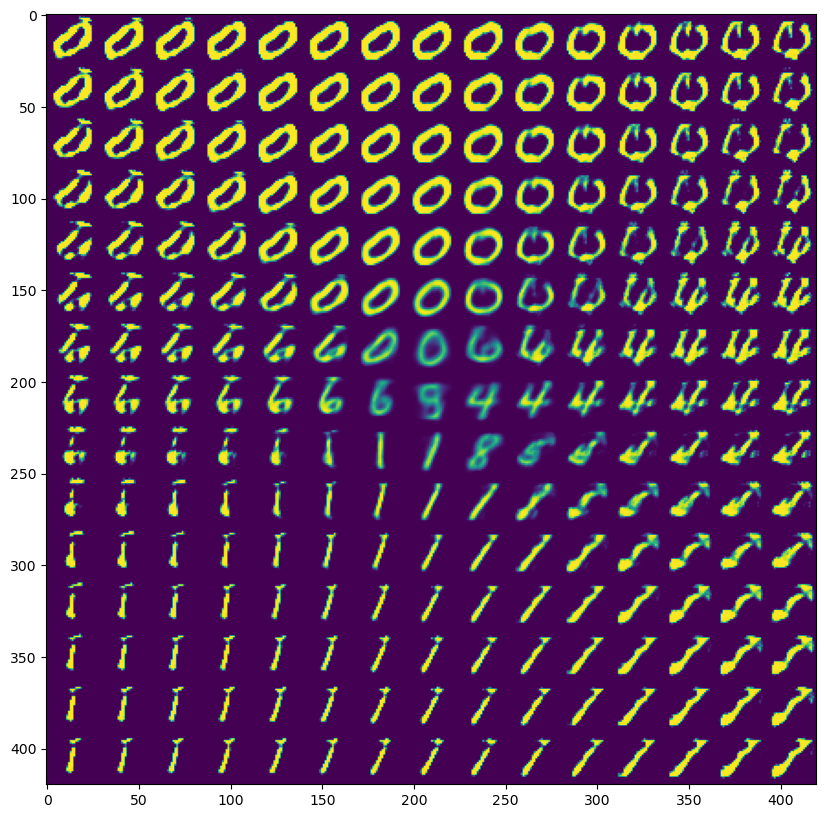

In [14]:
# show results
import matplotlib.pyplot as plt

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size
        ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()